# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** Frequentist AB testing (includes a quick review of concepts such as p-value, confidence interval)

<br></font>
</div>

# Import modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare

In [2]:
# setup the look and feel of the notebook
plt.rcParams['figure.figsize'] = 8, 6
sns.set_context('notebook', font_scale = 1.5, rc = {'lines.linewidth': 2.5})
sns.set_style('whitegrid')
sns.set_palette('deep')

# Create a couple of colors to use throughout the notebook
red = sns.xkcd_rgb['vermillion']
blue = sns.xkcd_rgb['dark sky blue']

Statistical inference is the process of analyzing sample data to gain insight into the population from which the data was collected and to investigate differences between data samples. In data analysis, we are often interested in the characteristics of some large population, but collecting data on the entire population may be infeasible. For example, leading up to U.S. presidential elections it could be very useful to know the political leanings of every single eligible voter, but surveying every voter is not feasible. Instead, we could poll some subset of the population, such as a thousand registered voters, and use that data to make inferences about the population as a whole.

## Point Estimate

Point estimates are estimates of population parameters based on sample data. For instance, if we wanted to know the average age of registered voters in the U.S., we could take a survey of registered voters and then use the average age of the respondents as a point estimate of the average age of the population as a whole. The average of a sample is known as the sample mean.
The sample mean is usually not exactly the same as the population mean. This difference can be caused by many factors including poor survey design, biased sampling methods and the randomness inherent to drawing a sample from a population. Let's investigate point estimates by generating a population of random age data and then drawing a sample from it to estimate the mean:

In [3]:
# generate some random number to serve as our population
np.random.seed(10)
population_ages1 = stats.poisson.rvs(loc = 18, mu = 35, size = 150000)
population_ages2 = stats.poisson.rvs(loc = 18, mu = 10, size = 100000)
population_ages = np.concatenate((population_ages1, population_ages2))
print('population mean:', np.mean(population_ages))

population mean: 43.002372


In [4]:
np.random.seed(6)
sample_ages = np.random.choice(population_ages, size = 500)
print('sample mean:', np.mean(sample_ages))

sample mean: 42.388


The experiment tells us that we'd expect the distribution of the population to be a similar shape to that of the sample, so we can assume that the mean of the sample and the population should have the same value. Note that we can't say that they exactly match, but it's the best estimate we can make.

The population mean is often denoted as $\mu$, the estimated population mean as $\hat{\mu}$, mean of the sample $\bar{x}$. So here we're basically saying $\hat{\mu} = \bar{x}$, where we're using the sample mean to estimate the mean of the population and usually the larger the size of our sample, the more accurate our point estimator for the estimated population mean is going to be.

## Sampling Distributions and The Central Limit Theorem

Many statistical procedures assume that data follows a normal distribution, because the normal distribution has nice properties like being symmetric and having the majority of the data clustered within a few standard deviations of the mean. Unfortunately, real world data is often not normally distributed and the distribution of a sample tends to mirror the distribution of the population. This means a sample taken from a population with a skewed distribution will also tend to be skewed.

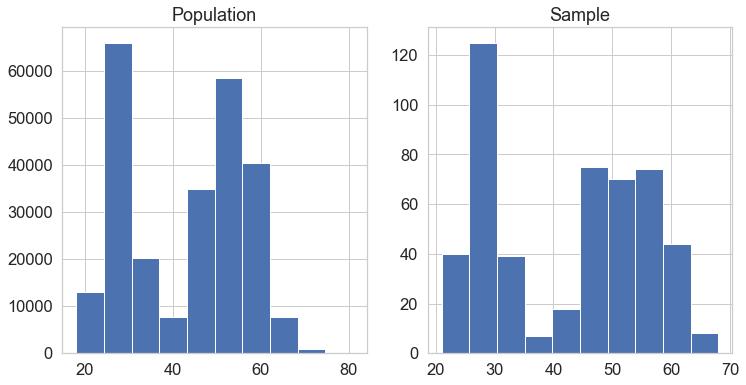

In [5]:
fig = plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.hist(population_ages)
plt.title('Population')
plt.subplot(1, 2, 2)
plt.hist(sample_ages)
plt.title('Sample')
plt.show()

The plot reveals the data is clearly not normal: instead of one symmetric bell curve, it has as bimodal distribution with two high density peaks. Because of this, the sample we drew from this population should have roughly the same shape and skew.

The sample has roughly the same shape as the underlying population. This suggests that we can't apply techniques that assume a normal distribution to this data set, since it is not normal. This leads to our next topic, the **central limit theorem**.

The central limit theorem is one of the most important results of probability theory and serves as the foundation of many methods of statistical analysis. At a high level, the theorem states the distribution of many sample means, known as a sampling distribution, will be normally distributed. This rule holds even if the underlying distribution itself is not normally distributed. As a result we can treat the sample mean as if it were drawn normal distribution. To illustrate, let's create a sampling distribution by taking 200 samples from our population and then making 200 point estimates of the mean:

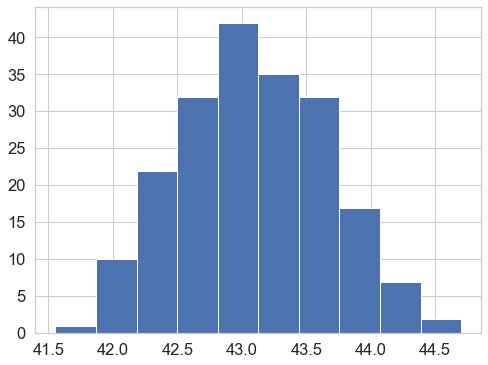

In [6]:
np.random.seed(10)
samples = 200
point_estimates = [np.random.choice(population_ages, size = 500).mean()
                   for _ in range(samples)]

plt.hist(point_estimates)
plt.show()

The sampling distribution appears to be roughly normal, despite the bimodal population distribution that the samples were drawn from. In addition, the mean of the sampling distribution approaches the true population mean:

In [7]:
population_ages.mean() - np.mean(point_estimates)

-0.08440799999999626

To hit the notion home, Central Limit Theorem states that that if we collect "a large number" of different samples mean from the population, the sampling distribution, the distribution of the samples mean you collected, will approximately take the shape of a normal distribution around the population mean no matter what the orginal population distribution is.

Knowing that the sampling distribution will take the shape of a normal distribution is what makes the theorem so powerful, as it is the foundation of concepts such as confidence intervals and margins of error in frequentist statistics.

## Confidence Interval

A point estimate can give us a rough idea of a population parameter like the mean, but estimates are prone to error. A confidence interval is a range of values above and below a point estimate that captures the true population parameter at some predetermined confidence level. For example, if you want to have a 95% chance of capturing the true population parameter with a point estimate and a corresponding confidence interval, we'd set our confidence level to 95%. Higher confidence levels result in a wider confidence intervals.

The interval is computed using the formula: 

$$
\begin{align}
\text{point estimate} \pm z * SE
\end{align}
$$

Where

- $z$ is called the **critical value** and it corresponds to the **confidence level** that we chose. Critical value is the number of standard deviations we'd have to go from the mean of the normal distribution to capture the proportion of the data associated with the desired confidence level. For instance, we know that roughly 95% of the data in a normal distribution lies within 2 standard deviations from the mean, so we could use 2 as the z-critical value for a 95% confidence interval (although it is more exact to get z-critical values with `stats.norm.ppf()`)
- $SE$ represents the **standard error**. Generally the standard error for a point estimate is estimated from the data and computed using a formula. For example, the standard error for the sample mean is $\frac{s}{ \sqrt{n} }$, where $s$ is the standard deviation and $n$ is the number of samples.
- The value $z * SE$ is called the **margin of error**.
- Note that this constructing confidence intervals framework can be easily adapted for any estimator that has a nearly normal sampling distribution. e.g. sample mean, two sample mean, sample proportion and two sample proportion (we'll later see). All we have to do this is change the way that we're calculating the standard error.

In [38]:
np.random.seed(10)
sample_size = 1000
sample = np.random.choice(population_ages, size = sample_size)
sample_mean = sample.mean()

confidence = 0.95
z_critical = stats.norm.ppf(q = confidence + (1 - confidence) / 2)
print('z-critical value:', z_critical)                     

pop_stdev = population_ages.std()
margin_of_error = z_critical * (pop_stdev / np.sqrt(sample_size))
confint = sample_mean - margin_of_error, sample_mean + margin_of_error
print('point esimate:', sample_mean)
print('Confidence interval:', confint)

z-critical value: 1.959963984540054
point esimate: 42.523
Confidence interval: (41.70306406882683, 43.34293593117317)


Notice that the confidence interval we calculated captures the true population mean of 43.0023.
Let's create several confidence intervals and plot them to get a better sense of what it means to "capture" the true mean:

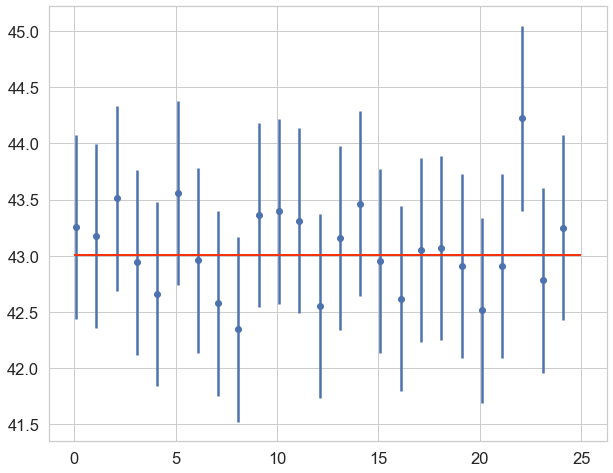

In [9]:
np.random.seed(12)
confidence = 0.95
sample_size = 1000

intervals = []
sample_means = []
for sample in range(25):
    sample = np.random.choice(population_ages, size = sample_size)
    sample_mean = sample.mean()
    sample_means.append(sample_mean)

    z_critical = stats.norm.ppf(q = confidence + (1 - confidence) / 2)                    
    pop_std = population_ages.std()
    margin_error = z_critical * (pop_stdev / np.sqrt(sample_size))
    confint = sample_mean - margin_error, sample_mean + margin_error 
    intervals.append(confint)
    

plt.figure(figsize = (10, 8))
plt.errorbar(x = np.arange(0.1, 25, 1), y = sample_means, 
             yerr = [(top - bot) / 2 for top, bot in intervals], fmt = 'o')

plt.hlines(xmin = 0, xmax = 25,
           y = population_ages.mean(), 
           linewidth = 2.0, color = red)
plt.show()

Notice that in the plot above, all but one of the 95% confidence intervals overlap the red line marking the true mean. This is to be expected: since a 95% confidence interval captures the true mean 95% of the time, we'd expect our interval to miss the true mean 5% of the time.

More formally, the definition of a 95% confidence interval means that **95% of confidence intervals, created based on random samples of the same size from the same population will contain the true population parameter**.

##  Hypothesis Testing

Lets starts off with a motivating example that asks the question "If you toss a coin 30 times and see 22 heads, is it a fair coin?"

We all know that a fair coin should come up heads roughly 15 out of 30 tosses, give or take, so it does seem unlikely to see so many heads. However, the skeptic might argue that even a fair coin could show 22 heads in 30 tosses from time-to-time. This could just be a chance event. So, the question would then be "how can you determine if we're tossing a fair coin?"

Let's start by first considering the probability of a single coin flip coming up heads and work our way up to 22 out of 30.

$$
\begin{align}
P(H) = \frac{1}{2}
\end{align}
$$

As our equation shows, the probability of a single coin toss turning up heads is exactly 50% since there is an equal chance of either heads or tails turning up. Taking this one step further, to determine the probability of getting 2 heads in a row with 2 coin tosses, we would need to multiply the probability of getting heads by the probability of getting heads again since the two events are independent of one another.

$$
\begin{align}
P(HH) = P(H) \cdot P(H) = P(H)^2 = \left(\frac{1}{2}\right)^2 = \frac{1}{4}
\end{align}
$$

Let's now take a look at a slightly different scenario and calculate the probability of getting 2 heads and 1 tails with 3 coin tosses. To get the actual probability of tossing 2 heads and 1 tails we will have to add the probabilities for all of the possible permutations, of which there are exactly three: HHT, HTH, and THH.

$$
\begin{align}
P(2H,1T) = P(HHT) + P(HTH) + P(THH) = \frac{1}{8} + \frac{1}{8} + \frac{1}{8} = \frac{3}{8}
\end{align}
$$

Another way we could do this is to use the binomial distribution:

$$
\begin{align}
P(N_H,N_T) = \binom{n}{k} p^{k} \left( 1 - p \right)^{n - k}
\end{align}
$$

Where 

- $n$ is number of coin flips
- $p$ is the probability of getting heads on each flip

The $\binom{n}{k}$ tells us how many ways are there to get $k$ heads our of $n$ total number of coin flips?" and the $p^k(1-p)^{n-k}$ answers the question "how likely is any given $k$ heads and $n-k$ tails?", multiply them together and we get the probability of getting exactly $k$ heads.

Now that we understand the classic method, let's use it to test whether we are actually tossing a fair coin.

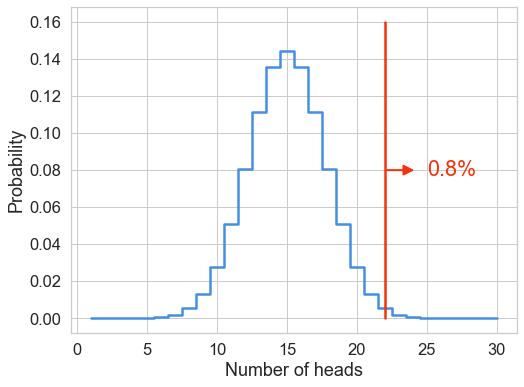

In [10]:
# Calculate the probability for every possible outcome
# of tossing a fair coin 30 k_range

k_range = range(1, 31)  # number of heads appearing
n = 30  # number of k_range tossing the coin
p = 0.5  # probability of coin appearing up as head

prob = stats.binom(n = n, p = p).pmf(k = k_range)

# Plot the probability distribution using the probabilities list 
# we created above.
plt.step(k_range, prob, where = 'mid', color = blue)
plt.xlabel('Number of heads')
plt.ylabel('Probability')
plt.plot((22, 22), (0, 0.1599), color = red)
plt.annotate('0.8%', xytext = (25, 0.08), xy = (22, 0.08), 
             va = 'center', color = red, size = 'large',
             arrowprops = {'arrowstyle': '<|-', 'lw': 2,
                           'color': red, 'shrinkA': 10})
plt.show()

The visualization above shows the probability distribution for flipping a fair coin 30 times. Using this visualization we can now determine the probability of getting, say for example, 12 heads in 30 flips, which looks to be about 8%. Notice that we've labeled our example of 22 heads as 0.8%. If we look at the probability of flipping exactly 22 heads, it looks likes to be a little less than 0.8%, in fact if we calculate it using the function from above, we get 0.5%.

In [11]:
prob = stats.binom(n = n, p = p).pmf(k = 22)
print('Probability of flipping 22 heads: {:0.1f}%'.format(prob * 100))

Probability of flipping 22 heads: 0.5%


So, then why do we have 0.8% labeled in our probability distribution above? Well, that's because we are showing the probability of getting at least 22 heads, which is also known as the **p-value**.

Let's pull back from our example and discuss formally about hypothesis testing. In standard frequentist statistic's hypothesis testing, we start with a null hypothesis that we usually call $H_0$ (pronouced as H naught), which represents our status quo. On the other hand, we also have an alternative hypothesis our $H_1$ that represents the question that we wish to answer, i.e. what we’re testing for.

After setting up our null and alternative hypothesis, we conduct a hypothesis test under the assumption that the null hypothesis is true. If the test results suggest that the data do not provide convincing evidence for the alternative hypothesis, we stick with the null hypothesis. If they do, then we reject the null hypothesis in favor of the alternative.

Frequentist statistic's hypothesis testing uses a p-value to weigh the strength of the evidence (what the data is telling you about the population). p-value is defined as **the probability of obtaining the observed or more extreme outcome, given that the null hypothesis is true (not the probability that the alternative hypthesis is true)**. It is a number between 0 and 1 and interpreted in the following way:

- A small p-value (typically <= 0.05, 0.05 is a commonly used threshold, the threshold is often denoted as $\alpha$) indicates strong evidence against the null hypothesis, so we reject the null hypothesis. This means that something interesting is going on and it’s not just noise!
- A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis. Although p-value is still in our favor, we cannot conclusively say that it was not due to random noise.
- p-values very close to the cutoff (0.05) are considered to be marginal (could go either way). If you carefully read good papers on these kind of topics, you will always see the p-values being reported so that the readers can draw their own conclusions.

**Example:**

Let's say that a pizza place claims their delivery times are 30 minutes or less on average. Now we think it's actually takes more than 30 minutes. We conduct a hypothesis test because we believe the null hypothesis, that the mean delivery time is 30 minutes maximum, is incorrect. This means that our alternative hypothesis is the mean time is greater than 30 minutes. We randomly sample some delivery times and run the data through the hypothesis test, and our p-value turns out to be 0.01, which is much less than 0.05.

In real terms, there is a probability of 0.01 that we will mistakenly reject the pizza place's claim that their delivery time is less than or equal to 30 minutes. Since typically we are willing to reject the null hypothesis when this probability is less than 0.05, we conclude that the pizza place is wrong; their delivery times are in fact more than 30 minutes on average.

Back with our coin toss example, the null hypothesis assumes we have a fair coin, and the way we determine if this hypothesis is true or not is by calculating how often flipping this fair coin 30 times would result in 22 or more heads. If we then take the number of times that we got 22 or more heads and divide that number by the total of all possible permutations of 30 coin tosses, we get the probability of tossing 22 or more heads with a fair coin. This probability is essentially our p-value.

In [12]:
def compute_pvalue(n, k, p):
    """Returns the p-value for binomial distribution"""
    k_range = range(k, n + 1)
    pvalue = stats.binom(n = n, p = p).pmf(k = k_range).sum()
    return pvalue


pvalue = compute_pvalue(n = 30, k = 22, p = 0.5)
print('P-value: {:0.1f}%'.format(pvalue * 100))

P-value: 0.8%


The role of p-value is used to check the validity of the null hypothesis. The way this is done is by agreeing upon some predetermined upper limit for our p-value, below which we will assume that our null hypothesis is false.

In other words, if our null hypothesis were true, and 22 heads in 30 flips could happen often enough by chance, we would expect to see it happen more often than the given threshold percentage of times. So, for example, if we chose 10% as our p-value threshold, then we would expect to see 22 or more heads show up at least 10% of the time to determine that this is a chance occurrence and not due to some bias in the coin. Historically, the generally accepted threshold has been 5%, and so if our p-value is less than 5%, we can then make the assumption that our coin may not be fair.

Running the code above gives us a p-value of roughly 0.8%, which matches the value in our probability distribution above and is also less than the 5% threshold needed to reject our null hypothesis, so it does look like we may have a biased coin.

In [13]:
# we can also use the binom_test function from scipy to
# perform the hypothesis testing
pvalue = stats.binom_test(x = 22, n = 30, p = 0.5, alternative = 'greater')
print('P-value: {:0.1f}%'.format(pvalue * 100))

P-value: 0.8%


## Simulation

Instead of using the statistical approach, the code below seeks to answer the same question of whether or not our coin is fair by running a large number of simulated coin flips and calculating the proportion of these experiments that resulted in at least 22 heads or more.

In [14]:
def coin_toss(n_simulation = 100000):
    """
    computing a fair coin resulting in at
    least 22 heads or more through simulation
    """
    pvalue = 0
    for i in range(n_simulation):
        # trials: 1 denotes head, 0 denotes tail
        trials = np.random.randint(2, size = 30)
        if trials.sum() >= 22:
            pvalue += 1

    pvalue /= n_simulation
    return pvalue


pvalue = coin_toss()
print('Simulated P-value: {:0.1f}%'.format(pvalue * 100))

Simulated P-value: 0.8%


The result of our simulations is 0.8%, the exact same result we got earlier when we calculated the p-value using the classical method above.

# Frequentist A/B testing

A/B testing is essentially a simple randomized trial. Randomized trials are (usually) considered the gold standard study design for evaluating the efficacy of new medical treatments, but they are also used much more widely in experimental research.

For example, when someone visits a website, the site sends them to one of two (or possibly more) different landing or home pages, and which one they are sent to is chosen at random. The purpose is to determine which page version generates a superior outcome, e.g. which page generates more advertising revenue, or which which page leads a greater proportion of visitors to continue visiting the site.

The key idea is that because we randomize which landing page (or treatment in the case of a randomized clinical trial) someone goes to, after a large number of visitors, the groups of people who visited the two pages are completely comparable in respect of all characteristics (e.g. age, gender, location, and anything else you can think of!). Because the two groups are comparable, we can compare the outcomes (e.g. amount of advertising revenue) between the two groups to obtain an unbiased, and fair, assessment of the relative effectiveness (in terms of our defined outcome) of the two designs.

Suppose for the moment that we've had two visitors to our site, and one visitor has been randomized to page A, and the other visitor to page B (note that it is entirely possible, with simple randomization, that both visitors could have both been sent to page A). Suppose next that the visitor to page A generated revenue, but the visitor to page B generated no revenue. Should we conclude that page A is superior to page B, in terms of revenue generation? Of course not. Because we have only sampled two visitors, it is entirely possible that the visitor to page A would have generated revenue even if they had been sent to page B, perhaps because they are very interested in the site's content, whereas perhaps the visitor to page B was not particularly interested in the site content, and was never going to generate revenue. We can overcome this problem by running the A/B testing for a sufficiently large number of visitors, such that the probability that the scenario described above is sufficiently small.

Scenario: We ran an A/B test with two different versions of a web page, a and b, for which we count the number of visitors and whether they convert or not. We can summarize this in a contingency table showing the frequency distribution of the events:

In [15]:
data = pd.DataFrame({
    'version': ['A', 'B'],
    'not_converted': [4514, 4473],
    'converted': [486, 527]
})[['version', 'not_converted', 'converted']]
data

,version,not_converted,converted
0,A,4514,486
1,B,4473,527


It is trivial to compute the conversion rate of each version, 486/(486 + 4514) = 9.72% for a and 10.5% for b. With such a relatively small difference, however, can we convincingly say that the version b converts better? To test the statistical significance of a result like this, a hypothesis testing can be used.

## Comparing Two Proportions

Let's formalize our thought process a little bit, suppose that we have obtained data from n visitors, $n_A$ of which have been (randomly) sent to page A, and $n_B$ of which have been sent to page B. Further, let $X_A$ and $X_B$ denote the number of visitors for whom we obtained a 'successful' outcome in the two groups. The proportion of successes in the two groups is then given by $\hat{p_A} = X_A/n_A$ and $\hat{p_B} = X_B/n_B$ respectively. The estimated difference in success rates is then give by the difference in proportions: $\hat{p_A} - \hat{p_B}$:

To assess whether we have statistical evidence that the two pages' success rates truely differ, we can perform a hypothesis test. The null hypothesis that we want to test is that the two pages' true success rates are equal, whereas the alternative is that they differ (one is higher than the other). If $p_A$ = the proportion of the page A population whom we obtained a successful outcome and $p_B$ = the proportion of the page B population whom we obtained a successful outcome then we are interested in testing the following hypothesis:

$$
\begin{align}
H_0:p_A = p_B \text{ versus } H_A: p_A \neq p_B
\end{align}
$$

Or put it in another way, the null hypothesis says that the factors 'page type' and 'outcome' are statistically independent of each other. In words, this means knowing which page someone is sent to tells you nothing about the chance that they will have a successful outcome. Now that we know what hypothesis test we're interested in, we'll have to derive the appropriate test statistic.

A test statistic is a single metric that can be used to evaluate the null hypothesis and the standard way to obtain this metric is to compute the z-score that measures how many standard deviations below or above the population mean a raw score is: 

$$
\begin{align}
z = \frac{x - \mu}{SE}
\end{align}
$$

Where:

- $\mu$ denotes the mean
- $SE$ or sometimes seen as the symbol $\sigma$ denotes the standard error, computed by $\frac{s}{\sqrt{n}}$, where $s$ denotes the standard error and $n$ denotes the number of samples

The following link contains an example of where this is applied in proportion hypothesis testing for those who feels uncomfortable with this concept. [Notes: Eberly College of Science STAT 414/415: Test About Proportions](https://onlinecourses.science.psu.edu/stat414/node/265)

For our test the underlying metric is a binary yes/no variable (event), which means the appropriate test statistic is a test for differences in proportions:

$$
\begin{align}
Z = \frac{ (\hat{p_A} - \hat{p_B}) - (p_A - p_B) }{SE(p_A - p_B)}
\end{align}
$$

The test statistic makes sense as it measuring the difference in the observed proportions and the estimated proportion, standardized by an estimate of the standard error of this quantity.

To compute the test statistic, we first need to find the standard deviation/variance of $p_A - p_B$:

$$
\begin{align}
Var(p_A - p_B)
&= Var(p_A) +  Var(p_B) \\
&= \frac{p_A (1 - p_A)}{n_A} + \frac{p_B (1 - p_B)}{n_B} \\
&= p (1 - p) \left( \frac{1}{n_A} + \frac{1}{n_B} \right)
\end{align}
$$

- The first step stems from that fact that, given that we know:
    - The variance of a random variable X is defined as $Var(X) = E[X^2] - E[X]^2$
    - The covariance between two random variable X and Y is defined as $Cov(X, Y) = E[(X - u_x)(y - u_y)] = E[XY] - E[X]E[Y]$
    - When conducting hypothesis test, we know that the two groups should be independent of each other, i.e. the covariance between the two should be 0

$$
\begin{align}
Var(X - Y)
&= E[(X - Y)(X - Y)] - E[X - Y]^2 \\
&= E[X^2 - 2XY + Y^2] - (u_x - u_y)^2 \\
&= E[X^2 - 2XY + Y^2] - u_x^2 + 2u_xu_y - u_y^2 \\
&= (E[X^2] - u_x^2) + (E[Y^2] - u_y^2) - 2(E[XY] - u_xu_y) \\
&= Var(X) + Var(Y) - 2 Cov(X, Y)
\end{align}
$$

- We're using the property that the variance of a binomial proportion is given by: $Var(p_A) = p_A (1 - p_A) / n_A$, the same can be applied for group B
- The third step comes from the fact that if we assume that the null hypothesis, $p_A = p_B$ is true, then the population proportions equal some common value $p$, that is, $p_A = p_B = p$. Since we don't know the assumed common population proportion $p$ any more than we know the proportions $p_A$ and $p_B$ of each population, we can estimate $p$ using the proportion of "successes" in the two combined, $\hat{p} = (X_A + X_B)/(n_A + n_B)$, which is commonly referred to as the **pooled probability**

During the third step, we utilized that fact that if we assume that the null hypothesis is true, then $p_A = p_B$, this also means $p_A - p_B = 0$. Given all of these information, the formula for our test statistic now becomes:

$$
\begin{align}
Z
&= \frac{ (\hat{p_A} - \hat{p_B}) - (p_A - p_B) }{SE(p_A - p_B)} \\
&= \frac{ (\hat{p_A} - \hat{p_B}) - 0 }{\sqrt{\hat{p} (1 - \hat{p}) \left( \frac{1}{n_A} + \frac{1}{n_B} \right)}}
\end{align}
$$

Where $\hat{p} = (X_A + X_B)/(n_A + n_B)$

In [16]:
def two_proprotions_test(success_a, size_a, success_b, size_b):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

In [17]:
success_a = 486
size_a = 5000
success_b = 527
size_b = 5000

zscore, pvalue = two_proprotions_test(success_a, size_a, success_b, size_b)
print('zscore = {:.3f}, pvalue = {:.3f}'.format(zscore, pvalue))

zscore = 1.359, pvalue = 0.174


In [18]:
# or we can use the implementation from statsmodels
# where we pass in the success (they call the argument counts)
# and the total number for each group (they call the argument nobs,
# number of observations)
counts = np.array([486, 527])
nobs = np.array([5000, 5000])

zscore, pvalue = proportions_ztest(counts, nobs, alternative = 'two-sided')
print('zscore = {:.3f}, pvalue = {:.3f}'.format(zscore, pvalue))

zscore = -1.359, pvalue = 0.174


Based on the fact that our p-value is not smaller than the 0.05 commonly used threshold, the test statistic tells us we do not have strong evidence against our null hypothesis, i.e. we do not have strong evidence that the two pages are not equally effective.

Apart from spitting out the p-value, we will also look at forming a confidence interval for $\hat{p_A} - \hat{p_B}$. If the number of trials in both groups is large, and the observed number of successes are not too small, we can calculate a 95% confidence interval using the formula:

$$
\begin{align}
\text{point estimate} \pm z * SE
&= (\hat{p_A} - \hat{p_B}) \pm z * \frac{p_A (1 - p_A)}{n_A} + \frac{p_B (1 - p_B)}{n_B}
\end{align}
$$

Note that when calculating the confidence interval because we no longer have the assumption that $p_A = p_B$ from our null hypothesis, thus we can't leverage this property and use the pooled probability.

In [19]:
def two_proprotions_confint(success_a, size_a, success_b, size_b, significance = 0.05):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its confidence interval;
    resulting confidence interval matches R's prop.test function
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
        
    significance : float, default 0.05
        Often denoted as alpha. Governs the chance of a false positive.
        A significance level of 0.05 means that there is a 5% chance of
        a false positive. In other words, our confidence level is
        1 - 0.05 = 0.95
        
    Returns
    -------
    prop_diff : float
        Difference between the two proportion
    
    confint : 1d ndarray
        Confidence interval of the two proportion test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
    se = np.sqrt(var)
    
    # z critical value
    confidence = 1 - significance
    z = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)

    # standard formula for the confidence interval
    # point-estimtate +- z * standard-error
    prop_diff = prop_b - prop_a
    confint = prop_diff + np.array([-1, 1]) * z * se
    return prop_diff, confint

In [20]:
prop_diff, confint = two_proprotions_confint(success_a, size_a, success_b, size_b)
print('estimate difference:', prop_diff)
print('confidence interval:', confint)

estimate difference: 0.008199999999999999
confidence interval: [-0.00362633  0.02002633]


Up till this point, we've been using the 5000 as the total number of observations/samples that are involved in the A/B testing process. The next question that we'll address is, in real world scenarios, how many obeservations do we need in order to draw a valid verdict on the test result. This leads us to our next topic **power**.

## Introducing Power

In the world of hypothesis testing, rejecting the null hypothesis when it is actually true is called a type 1 error, often denoted as $\alpha$. Committing a type 1 error is a false positive because we end up recommending something that does not work. Conversely, a type 2 error, often denoted as $\beta$, occurs when we do not reject the null hypothesis when it is actually false. This is a false negative because we end up sitting on our hands when we should have taken action. We need to consider both types of errors when choosing the sample size.

Two important probabilities related to type 1 and type 2 error are:

- **Significance level:** Governs the chance of a false positive. A significance level of 0.05 means that there is a 5% chance of a false positive. Choosing level of significance is an arbitrary task, but for many applications, a level of 5% is chosen, for no better reason than that it is conventional
- **Statistical power** Power of 0.80 means that there is an 80% chance that if there was an effect, we would detect it (or a 20% chance that we'd miss the effect). In other words, power is equivalent to $1 - \beta$. There are no formal standards for power, most researchers assess the power of their tests using 0.80 for adequacy

| Scenario       | $H_0$ is true                      | $H_0$ is false            |
|:--------------:|:----------------------------------:|:-------------------------:|
|  Accept $H_0$  |  Correct Decision                  |  Type 2 Error (1 - power) |
|  Reject $H_0$  |  Type 1 Error (significance level) |  Correct decision         |

The concepts of power and significance level can seem somewhat convoluted at first glance. A good way to get a feel for the underlying mechanics is to plot the probability distribution of $Z$ assuming that the null hypothesis is true. Then do the same assuming that the alternative hypothesis is true, and overlay the two plots.

Consider the following example: $H_0: p_A = p_B, H_1: p_A > p_B$. A one-sided test was chosen here for charting-simplicity.

- Total sample size, N=5,000 (assume equal sample sizes for the control and experiment groups, meaning exactly 2,500 in each group)
- Say we've decided we need to observe a difference of 0.02 in order to for us to be satisfied the intervention worked (i.e., assuming that our original baseline, $p_B$ was 0.08, then we want $p_A = 0.10$). We will discuss how to make this decision later in the post

In [21]:
def plot_power(min_diff, prob_b, size_a, size_b, significance = 0.05):
    """illustrating power through a one-tailed hypothesis test"""
    
    # obtain the z-score for the minimum detectable
    # difference using proportion_ztest
    prob_a = prob_b + min_diff
    count_a = size_a * prob_a
    count_b = size_b * prob_b
    counts = np.array([count_a, count_b])
    nobs = np.array([size_a, size_b])
    zscore, _ = proportions_ztest(counts, nobs, alternative = 'larger')

    # distribution for the null hypothesis, h0
    # and alternative hypothesis, h1
    h0 = stats.norm(loc = 0, scale = 1)
    h1 = stats.norm(loc = zscore, scale = 1)

    # points that are greater than the zscore for the
    # specified significance level
    x = np.linspace(-5, 6, num = 100)
    threshold = h0.ppf(1 - significance)
    mask = x > threshold
    
    # power is the area after the threshold, i.e.
    # 1 - the cumulative distribution function of that point
    power = np.round(1 - h1.cdf(threshold), 2)

    hypotheses = [h1, h0]
    labels = ['$H_1$ is true', '$H_0$ is true']
    for hypothesis, label in zip(hypotheses, labels):
        y = hypothesis.pdf(x)
        line = plt.plot(x, y, label = label)  
        plt.fill_between(x = x[mask], y1 = 0.0, y2 = y[mask],
                         alpha = 0.2, color = line[0].get_color())
    
    title = 'p1: {}, p2: {}, size1: {}, size2: {}, power: {}'
    plt.title(title.format(prob_a, prob_b, size_a, size_b, power))
    plt.legend()
    plt.tight_layout()
    plt.show()

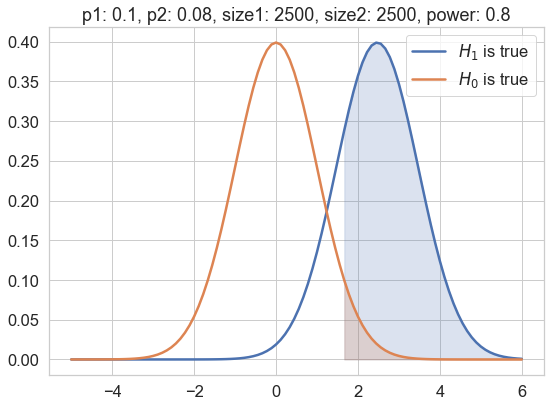

In [22]:
prob_b = 0.08
min_diff = 0.02
size_a = 2500
size_b = 2500

plot_power(min_diff, prob_b, size_a, size_b)

The shaded green area denotes the significance region, while the shaded blue area denotes the power (note that it includes the shaded green area). Note that if we pick a smaller N, or a smaller probability difference between the control and experiment group, the power drops (the shaded blue area decreases), meaning that if there’s is in fact a change, there’s lesser percent chance that we’ll detect it.

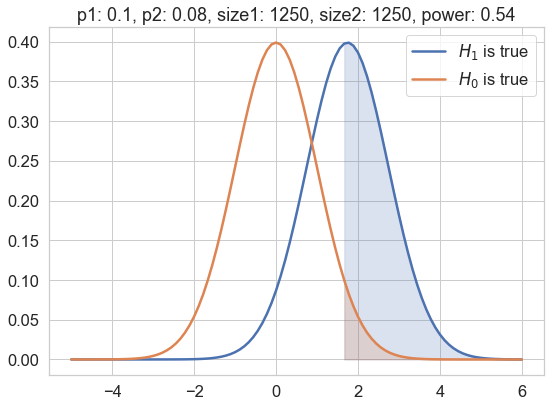

In [23]:
# smaller N
prob_b = 0.08
min_diff = 0.02
size_a = 1250
size_b = 1250

plot_power(min_diff, prob_b, size_a, size_b)

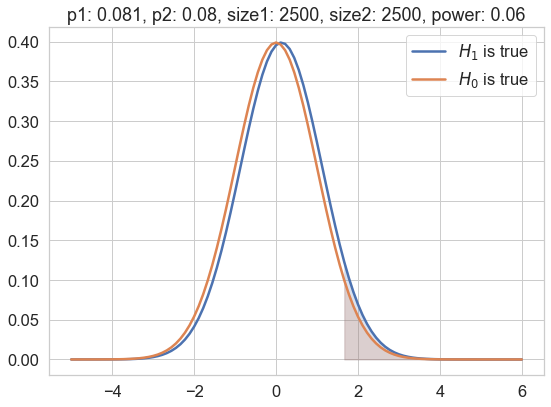

In [24]:
# smaller probability difference
prob_b = 0.08
min_diff = 0.001
size_a = 2500
size_b = 2500

plot_power(min_diff, prob_b, size_a, size_b)

The following link illustrates power for a two-sided hypothesis test for those interested. [Youtube: Calculating Power and the Probability of a Type II Error (A Two-Tailed Example)](https://www.youtube.com/watch?v=NbeHZp23ubs)

## Determining Sample Size

Say we've followed the rule of thumb and required the significance level to be 5% and the power to be 80%. This means we have now specified the two key components of a power analysis.

- A decision rule of when to reject the null hypothesis. We reject the null when the p-value is less than 5%.
- Our tolerance for committing type 2 error (1−80%=20%).

To actually solve for the equation of finding the suitable sample size, we also need to specify the detectable difference, i.e. the level of impact we want to be able to detect with our test.
 
In order to explain the dynamics behind this, we'll return to the definition of power: the power is the probability of rejecting the null hypothesis when it is false. Hence for us to calculate the power, we need to define what "false" means to us in the context of the study. In other words, how much impact, i.e., difference between test and control, do we need to observe in order to reject the null hypothesis and conclude that the action worked?

Let's consider two illustrative examples: if we think that an event rate reduction of, say, $10^{-10}$ is enough to reject the null hypothesis, then we need a very large sample size to get a power of 80%. This is pretty easy to deduce from the charts above: if the difference in event rates between test and control is a small number like $10^{-10}$, the null and alternative probability distributions will be nearly indistinguishable. Hence we will need to increase the sample size in order to move the alternative distribution to the right and gain power. Conversely, if we only require a reduction of 0.02 in order to claim success, we can make do with a much smaller sample size. 

> The smaller the detectable difference, the larger the required sample size

Here's how we could conduct a power test in python:

In [25]:
import statsmodels.stats.api as sms


def compute_sample_size(prop1, min_diff, significance = 0.05, power = 0.8):
    """
    Computes the sample sized required for a two-proportion A/B test;
    result matches R's pwr.2p.test from the pwr package
    
    Parameters
    ----------
    prop1 : float
        The baseline proportion, e.g. conversion rate 
        
    min_diff : float
        Minimum detectable difference
        
    significance : float, default 0.05
        Often denoted as alpha. Governs the chance of a false positive.
        A significance level of 0.05 means that there is a 5% chance of
        a false positive. In other words, our confidence level is
        1 - 0.05 = 0.95
    
    power : float, default 0.8
        Often denoted as beta. Power of 0.80 means that there is an 80%
        chance that if there was an effect, we would detect it
        (or a 20% chance that we'd miss the effect)
        
    Returns
    -------
    sample_size : int
        Required sample size for each group of the experiment

    References
    ----------
    R pwr package's vignette
    - https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html

    Stackoverflow: Is there a python (scipy) function to determine parameters
    needed to obtain a target power?
    - https://stackoverflow.com/questions/15204070/is-there-a-python-scipy-function-to-determine-parameters-needed-to-obtain-a-ta
    """
    prop2 = prop1 + min_diff
    effect_size = sms.proportion_effectsize(prop1, prop2)
    sample_size = sms.NormalIndPower().solve_power(
        effect_size, power = power, alpha = significance, ratio = 1)
    
    return sample_size

In [26]:
sample_size = compute_sample_size(prop1 = 0.1, min_diff = 0.02)
print('sample size required per group:', sample_size)

sample size required per group: 3834.5957398840183


Note that the printed result is the sample size needed for each group!

Unlike the significance level and the power, there are no plug-and-play values we can use for the detectable difference. The key is to define what "pay off" means for the study at hand, which depends on what the adverse event is a well as the cost of the action. Two guiding principles:

- **Avoid wasteful sampling** Let’s say it takes an absolute difference of 0.02 between test and control in order for the treatment to pay off. In this case, aiming for a 0.01 detectable difference would just lead to more precision than we really need. Why have the ability to detect 0.01 if we don’t really care about a 0.01 difference? In many cases, sampling for unnecessary precision can be costly and a waste of time
- **Avoid missed opportunities** Conversely, if we are analyzing a sensitive metric where small changes can have a large impact e.g. email campaigns, we have to aim for a small detectable difference. If we choose an insufficient sample size, we may end up sitting on our hands and missing an opportunity (type 2 error)

Hence, choosing the minimum detectable difference should be a cross-functional analysis/discussion between the data scientist and the business stakeholder. Once there is a viable range for the detectable difference, we can evaluate the sample size required for each option. For example, let’s say that $p1=0.10$ and we want the detectable difference to be between 0.01 and 0.03. Clearly, we’d rather be able to detect a difference of 0.01, but it may be too costly and hence we want to evaluate more conservative options as well.

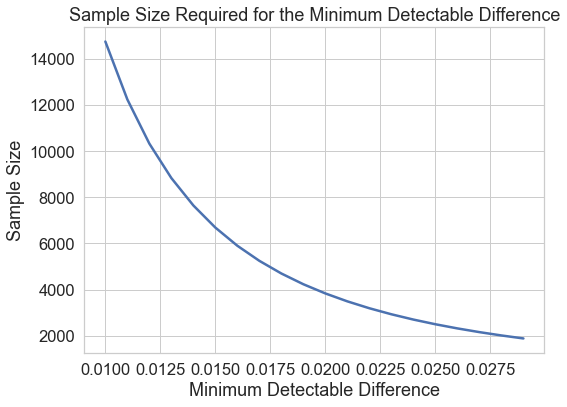

In [27]:
# calculate the the required sample size
# for a range of minimum detectable difference
sample_sizes = []
min_diffs = np.arange(0.01, 0.03, 0.001)
for min_diff in min_diffs:
    sample_size = compute_sample_size(prop1 = 0.1, min_diff = min_diff)
    sample_sizes.append(sample_size)

plt.plot(min_diffs, sample_sizes)
plt.title('Sample Size Required for the Minimum Detectable Difference')
plt.ylabel('Sample Size')
plt.xlabel('Minimum Detectable Difference')
plt.tight_layout()
plt.show()

From the graph, we can see that we need roughly 10x more observations to get a detectable difference of 0.01 compared to 0.03.

The following section is an alternative way of conducting a test statistic for proportional A/B test, feel free to skip it as it will not affect the understanding of later section.

## Alternative View of the Test Statistic

There are two types of the chi-squared test, goodness of fit and test of independence, where the latter is more applicable for our use case here. We start off by converting the contingency table into a probability matrix by dividing each element with the total frequencies:

In [28]:
cols = ['not_converted', 'converted']
data[cols] = data[cols] / data[cols].values.sum()
data

,version,not_converted,converted
0,A,0.4514,0.0486
1,B,0.4473,0.0527


We will denote $V$ as the version of the web page ($a$ or $b$) and $C$ as the conversion result, $f$ (false did not convert) or $t$ (true did in fact convert). The table that we computed above, which this the data that we observed can then be translated into this form:


| Version (V) | $f$ (false did not convert)  | $t$ (true did in fact convert) |
|:-----------:|:----------------------------:|:------------------------------:|
|    A        | $P(V = a, C = f)$            | $P(V = a, C = t)$              |
|    B        | $P(V = b, C = f)$            | $P(V = b, C = t)$              |


Now, our interest is whether the conversion $C$ depends on the page version $V$, and if it does, to learn which version converts better. In probability theory, the events $C$ and $V$ are said to be independent if the joint probability can be computed by $P(V, C) = P(V) \cdot P(C)$, where $P(V)$ and $P(C)$ are marginal probabilities of $V$ and $C$, respectively. It is straightforward to compute the marginal probabilities from row and column marginals:

$$P(V = a) = \frac{4514 + 486}{10000}  \hspace{1cm} P(V = b) = \frac{4473 + 527}{10000}$$
$$P(C = f) = \frac{4514 + 4473}{10000} \hspace{1cm} P(C = t) = \frac{486 + 527}{10000}$$

Our null hypothesis is $V$ and $C$ are independent, in which case the elements of the matrix, a.k.a the distribution that we're expecting is equivalent to:

| Version (V) | $f$ (false did not convert)  | $t$ (true did in fact convert) |
|:-----------:|:----------------------------:|:------------------------------:|
|    A        | $P(V = a)P(C = f)$           | $P(V = a)P(C = t)$             |
|    B        | $P(V = b)P(C = f)$           | $P(V = b)P(C = t)$             |


The conversion $C$ is said to be dependent on the version $V$ of the web site if this null hypothesis is rejected. Hence rejecting the null hypothesis means that one version is better at converting than the other.

When dealing with counts and investigating how far the observed counts are from the expected counts, we use a test statistic called the **chi-square test**. The chi-squared test compares an observed distribution $O_{ij}$ to an expected distribution $E_{ij}$:

$$
\begin{align}
\chi^2 = \sum_{i,j} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
\end{align}
$$

It's calculated as the observed minus the expected for each cell squared divided by the expected counts, the division with the expected counts makes final result proportional to our expected frequency. After performing the computation for each cell, we want to sum this over all the cells (levels of the categorical variable).

This $\chi^2$ probability distribution has only one parameter, the degrees of freedom. It influences the shape, the center and the spread of the chi-square distribution.

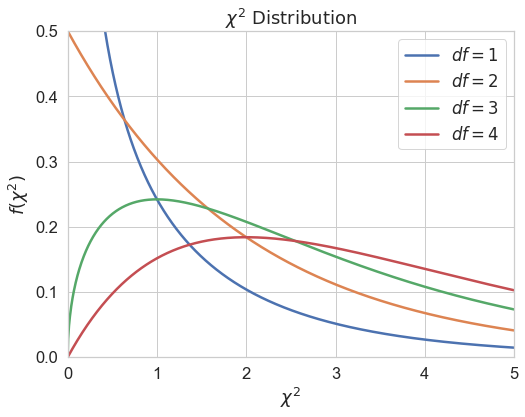

In [29]:
# chi square distribution with varying degrees of freedom
fig = plt.figure(figsize = (8, 6))
x = np.linspace(0, 5, 1000)
deg_of_freedom = [1, 2, 3, 4]
for df in deg_of_freedom:
    plt.plot(x, stats.chi2.pdf(x, df), label = '$df={}$'.format(df))

plt.xlim(0, 5)
plt.ylim(0, 0.5)
plt.xlabel('$\chi^2$')
plt.ylabel('$f(\chi^2)$')
plt.title('$\chi^2\ \mathrm{Distribution}$')
plt.legend()
plt.show()

chi-square distribution gives a way of measuring the difference between the frequencies we observe and the frequencies we expect. The smaller the value of $\chi^2$, the smaller the difference overall between the observed and expected frequencies. The way to compute the degree of freedom for the test of independence using a $r \times c$ contingency matrix is:

$$
\begin{align}
df = (r - 1)(c - 1)
\end{align}
$$

Where $r$ denotes the number of rows and $c$ denotes the number of columns. The rationale behind this calculation is because degrees of freedom is the number of expected frequencies we have to calculate independently after taking into account any restrictions. The restrictions come from the row and column sum constraints, but decreased by one because the last entry in the table/matrix is determined by either the row or column sum on that row/column.

Fortunately it is very straightforward to carry out this hypothesis testing using packages. All we need is to supply the function with a contingency matrix and it will return the $\chi^2$ statistic and the corresponding p-value:

In [30]:
# we can use the proportions_chisquare function,
# where we pass in the number of successes and
# the total number of trials/observation
count = np.array([486, 527])
nobs = np.array([5000, 5000])

# note that in this case (a two sample case with two sided
# alternative), the test produces the same value as porportions_ztest
# since the chi-square distribution is the square of a normal distribution
chisq, pvalue, table = proportions_chisquare(count, nobs)
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 1.8464754013996965, pvalue = 0.17419388311716985


In [31]:
# or the chi2_contingency function where we pass
# in the observed contingency table
observed = np.array([[4514,  486], [4473,  527]])

# more about the correction = False parameter later
result = stats.chi2_contingency(observed, correction = False)
chisq, pvalue = result[:2]
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 1.8464754013996965, pvalue = 0.17419388311716985


The result for our experiment has a  $\chi^2 = 1.74$ and $p = 0.185$. Since the p-value is greater than the standard threshold 0.05, we cannot reject the null hypothesis that the page version and the conversion is independent. Therefore the difference in the conversion rates is not statistically significant.

For a 2 x 2 contingency table, Yate’s chi-squared test is commonly used. This applies a correction of the form:

$$
\begin{align}
\chi^2_{Yate's} = \sum_{i,j} \frac{(\big|O_{ij} - E_{ij}\big| - 0.5)^2}{E_{ij}}
\end{align}
$$

to account for an error between the observed discrete distribution and the continuous chi-squared distribution (the step of -0.5 is often referred to as continuity correction).

In [32]:
# we can use the correcction form, by specifying
# correction = True
result = stats.chi2_contingency(observed, correction = True)
chisq, pvalue = result[:2]
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 1.7575018692680038, pvalue = 0.18493641552090323


Again, our pvalue is greater than the critical value, hence we simply would not reject the null hypothesis (that there is no relationship between the categorical variables).

> Side note: in practice, we want to make sure that each particular scenario or cell has at least five expected counts before employing the chi-square test.

# Frequentist A/B Testing Workflow

After diving into the technical details of conducting a frequentist A/B testing, we will now introduce one possible template/workflow/thought-process for conducting A/B testing.

## Formulate Business Goals & Hypothesis Test

**Define Business Goal**

Every project or plan or test always starts with a goal e.g. A business objective for an online flower store is to "Increase our sales by receiving online orders for our bouquets"

**Formulate A/B Test**

The crux of A/B testing can be summarized into one sentence:

> If **[Variable]**, then **[Result]**, because **[Rationale]**

- **[Variable]** is the element such as call to action, media that we've modified
- **[Result]** is basically what we expect to see, such as more clicks, more sign-ups. The effect size of [Result] will be determined by the data
- **[Rationale]** what assumptions will be proven right/wrong after the experiment

### Result

We start by asking ourselves, what result are we expecting out of this test? To do this, we need to:

- **Define our Key Performance Indicators.** e.g. Our flower store's business objective is to sell bouquets. Our KPI could be number of bouquets sold online.
- **Define our target metrics.** e.g. For our imaginary flower store, we can define a monthly target of 175 bouquets sold.

### Rationale

A lot of times, people have the idea that A/B testing is panacea, too many people think they'll just guess their way to great conversion and revenue, when truly successful tests are typically much more complicated than that.

After defining the high level goal and knowing the result that we're aiming for, find out (not guess) which parts of our business are underperforming or trending and why. Ways to perform this step are:

**Quantitative methods** We can start by looking at quantitative data if we have any. These methods do a much better job answering how many and how much types of questions.

Say we're a website, we can take a look at our conversion funnel and examine the flow from the persuasive end (top of the funnel) and the transactional end (bottom of the funnel). e.g. We can identify problems by starting from the top 5 highest bounce rate pages. During the examination, segment to spot underlying underperformance or trends.

- **Segment by source:** Separate people who arrive on your website from e-mail campaigns, google, twitter, youtube, etc. Find answers to questions like: Is there a difference between bounce rates for those segments? Is there a difference in Visitor Loyalty between those who came from Youtube versus those who came from Twitter? What products do people who come from Youtube care about more than people who come from Google?
- **Segment by behavior:** Focus on groups of people who have similar behaviors For example, we can separate out people who visit more than ten times a month versus those that visit only twice. Do these people look for products in different price ranges? Are they from different regions? Or separate people out by the products they purchase, by order size, by people who have signed up.

e.g. We're looking at our metric of total active users over time and we see a spike in one of the timelines. After confirming that this is not caused by seasonal variation, we can look at different segment of our visitors to see if one of the segment is causing the spike. Suppose we have chosen segment to be geographic, it might just happen that we’ve identify a large proportion of the traffic is generated by a specific region

During the process we should ask ourselves: 1) Why is it happening? 2) How can we spread the success of other areas of the site. And it might be best for us to use qualitative methods to dig deeper and understand why, i.e. the rationale that behind the hypothesis test.

**Qualitative methods:** Ideas for gathering qualitative data to understand the why a problem exists and how to potentially fix it:

- Add an exit survey on our site, asking why our visitors did/didn't complete the goal
- Track what customers are saying in social media and on review sites
- User Experience Group (this is the preferred way as it is going really deep with a few users and ask qualitative questions such as what's holding them back from doing what we hope they'll do, e.g. converting)

### Variable

Upon identifying the overall business goal and the possible issue, it's time to determine the variable, which is the element that we'll be testing for. e.g. we've identified through quantitative method that less than one percent of visitors sign up for our newsletter and after conducting qualitative studies it's because the call to action wording does not resonate with the audience, then our variable will be changing the call to action's wording.

Note that we may have multiple ideas for our variable, in that case we can collate all the ideas, prioritize them based on three simple metrics:

- **Potential** How much potential for a conversion rate increase? We can check to see if this kind of idea worked before.
- **Importance** How many visitors will be impacted from the test?
- **Ease** How easy is it to implement the test? Go for the low-hanging fruit first. 

Every test that's developed should documented so that we can review and prioritize ideas that are inspired by winning tests. Some ideas worth experimenting are: Headlines, CTA (call to actions), check-out pages, forms and the elements include:

- Wording. e.g. Call to action or value proposition.
- Image. e.g. Replacing a general logistics image with the image of an actual employee.
- Layout. e.g. Increased the size of the contact form or amount of content on the page.

---

So given all of that a strong A/B test hypothesis may be:

- If the call to action text is changed to "Complete My Order", the conversion rates in the checkout will increase, because the copy is more specific and personalized
- If the navigation link is removed from checkout pages, the conversation rate will increase because our website analytics shows portions of our traffic drop out of the funnel by clicking on those links

## Quantitative A/B testing

Suppose we're running an educational platform and your A/B testing hypothesis is : Will changing the "Start Now" button from orange to pink increase how many students explore the platform's courses. So in this case the metric that's use to evaluate the change's performance is the click through probability (unique visitors who click the button / unique visitors to page). Note that it is often times impractical to use metrices such as total number of students that completed the course as it often takes weeks or months before a student can do that.

Next we will jot down the hypothesis that we wish to test out, in our case the null and alternative hypothesis would be:

- $H_0$: The experimental and control groups have the same probability of clicking the button. Or equivalent to saying that the differences of the two groups' probability is 0
- $H_1$: The two groups have different probability of completing a clicking the button

### Define the Size and Duration

After we've defined our hypothesis, the first question that comes into mind is how many tests do we need to run, or in a sense how long should the test last in order for us to make our decisions. To do that we can use a power analysis for two independent samples:

Now suppose that our current baseline is 0.1, i.e. there's a 10 percent chance that people who saw the button will click it and we wish to detect a change of 2 percent in the click through rate (This change is quite high for online experiment).

In [33]:
sample_size = compute_sample_size(prop1 = 0.1, min_diff = 0.02)
print('sample size required per group:', sample_size)

sample size required per group: 3834.5957398840183


The result shows that we need at least 3841 sample size for each scenario to detect if there will actually be a 2 percent more than baseline click through probability. Note that this is only telling us the minimum sample size required per group, we still need to decide when do we want to run the experiment and for how long.

e.g. Suppose we’ve chosen the goal to increase click-through rates, which is defined by the unique number of people who click the button versus the number of users who visited the page that the button was located. But to actually use the definition, we’ll also have to address some other questions. Such as, if the same user visits the page once and comes back a week or two later, do we still only want to count that once? Thus we’ll also need to specify a time period

To account for this, if 99% of our visitors convert after 1 week, then we should do the following.

- Run our test for two weeks
- Include in the test only users who show up in the first week. If a user shows up on day 13, we have not given them enough time to convert (click-through)
- At the end of the test, if a user who showed up on day 2 converts more than 7 days after he/she first arrived, he must be counted as a non-conversion

There will be more discussion about this in the A/B Test Caveats & Advice section.

For this step, there is also an online calculator that non-technical audience could use. [Online Calculator: Sample Size Calculator](http://www.evanmiller.org/ab-testing/sample-size.html)

## Define the Population

Another consideration is what fraction of the traffic are we going to send through the experiment. The key is to identify which population of our users will be affected by our experiment, we might want to target our experiment to that traffic (e.g. changing features specific to one language’s users) so that the rest of the population won’t dilute the effect.

Next, depending on the problem we're looking at, we might want to use a cohort instead of a population. A cohort makes much more sense than looking at the entire population when testing out learning effects, examining user retention or anything else that requires the users to be established for some reason.

A quick note on cohort. The gist of cohort analysis is basically putting our customers into buckets so we can track their behaviours over a period of time. The term cohort stands for a group of customers grouped by the timeline (can be week, month) where they first made a purchase (can be a different action that’s valuable to the business). Having similar traits makes the two groups more comparable.

e.g. You’re an educational platform has an existing course that’s already up and running. Some of the students have completed the course, some of them are midway through and there’re students who have not yet started. If you want to change the structure of of one of the lessons to see if it improves the completion rate of the entire course and they started the experiment at time X. For students who have started before the experiment initiated they may have already finished the lesson already leading to the fact that they may not even see the change. So taking the whole population of students and running the experiment on them isn’t what you want. Instead, you want to segment out the cohort, the group of customers, that started the lesson as the experiment was launched and split that into an experiment and control group.

## Evaluating Result

Suppose we have ran the test and obtained the total number of sample sizes and the total number of successes for both groups. Given these variables we can use it to calculate whether the proportional change was due to variation or not.

In [34]:
# made-up results
success_a = 386
size_a = 3834
success_b = 530
size_b = 3842

prob_diff, confint = two_proprotions_confint(success_a, size_a, success_b, size_b)
print('estimate difference:', prob_diff)
print('confidence interval:', confint)

estimate difference: 0.03727084197203194
confidence interval: [0.02279256 0.05174912]


In order to launch a change, the change should be larger than the minimum detectable change that we wished to detect. In our case, the value we've set was 0.02. Base on the result above, we can denote that since even the lower bound of the confidence interval is larger than the value, we'll definitely launch the newer version of the click button.

There is also an online calculator that we can use to perform the proportion test. [Online Calculator: AB Testguide](https://abtestguide.com/calc/)

## Sanity Check

When running experiments, especially online experiments, it's a good idea to check whether the experiments were setup properly, i.e. are the users being split equally amongst the two groups. For instance, after running your experiment for a week, you've discovered that the total number of users assigned to the control group is 64454 and the total number of users assigned to the experiment group 61818. How would you figure out whether the difference is within expectation given that each user is randomly assigned to the control or experiment group with a probability of 0.5? It's usually good idea to check this.

This is equivalent to saying out of a total 126272 (64454 + 61818) users, is it surprising to see if 64454 users are assigned to the control group? This is essentially a binomial distribution, thus, knowing this information, we can construct a confidence interval to test if the number lies within the confidence interval. The confidence interval can be calculated by the mean plus and minus the z-score times the standard error. 


\begin{align}
mean \pm Z * \sqrt{np(1 - p)}
\end{align}

Where the mean is expected number of users in the control / experiment group, which is simply the total number of the two groups times 0.5, since the probability of a user falling into either group is 50%. And the standard error of a binomial distribution is $\sqrt{np(1-p)}$.

In [35]:
def sanity_check(size1, size2, significance = 0.05):
    n = size1 + size2
    confidence = 1 - significance
    z = stats.norm.ppf(confidence + significance / 2)
    confint = n * 0.5 + np.array([-1, 1]) * z * np.sqrt(n * 0.5 * 0.5)
    return confint

In [36]:
size1 = 64454
size2 = 61818
sanity_check(size1, size2)

array([62787.76563631, 63484.23436369])

The result shows that 64454 does not lie within the range of the computed 95 percent confidence interval and therefore it indicates the two groups may not be split equally. 

When this kind of situation happens it's usually best to go back to the day by day data to get a better idea of what could be going wrong. One good thing is to check whether any particular day stands out, or it is just an overall pattern. If it is an overall pattern, then it is suggested that we should check if something went wrong with the experiment setup before proceeding on to analyzing the result.

# A/B Test Caveats & Advices

## Avoid Biased Stopping Times

NO PEEKING. When running an A/B test, we should avoid stopping the experiment as soon as the results "look" significant. Using a stopping time that is dependent upon the results of the experiment can inflate our false-positive rate substantially.

Recall that in many experiments, we set the significance threshold to be 5% (or a p-value threshold of 0.05). This means that we'll accept that Variation A is better than Variation B if A beats B by a margin large enough that a false positive would only happen 5% of the time. If we, however, were to check the experiment with the intent of stopping it if it shows significance, then every time we perform the significance test, we're essentially inflating our false-positive rate. To be more explicit, every time we perform the test there's a 5% chance of false-positive, so in other words, 95% chance of drawing the right conclusion, if we perform it again then that means we need both test to be correct to draw the right conclusion, i.e. the probability of both test giving us the correct result now becomes (1 - 5%)(1 - 5%) and the probability of committing a false positive error is now: 1 - (1 - 5%)(1 - 5%).

In [37]:
# the false positive rate of conducting the test for n times
significance = 0.05

print('conducting the test 2 times', 1 - (1 - significance) ** 2)
print('conducting the test 10 times', 1 - (1 - significance) ** 10)

conducting the test 2 times 0.09750000000000003
conducting the test 10 times 0.4012630607616213


The easiest way to avoid this problem is to **choose a stopping time that's independent of the test results**. We could, for example, decide in advance to run the test for a fix amount of time, no matter the results we observed during the test's tenure. Thus just like in the template above, if 99% of our visitors convert after 1 week, then we should do the following.

- Run your test for two weeks.
- Include in the test only users who show up in the first week. If a user shows up on day 13, you have not given them enough time to convert.
- At the end of the test, if a user who showed up on day 2 converts more than 7 days after he first arrived, he must be counted as a non-conversion.

Or we could decide to run the test until each bucket has received more than 10,000 visitors, again ignoring the test results until that condition is met. There are tests like power tests that let's us determine how many tests we should run before we make a conclusion about the result. Although we should be very careful with this, because the truth is: It's not really the number of conversions that matters; it's whether the time frame of the test is long enough to capture variations on your site. 

For instance, the website traffic may behave one way during the day and another way at night (the same holds on weekdays and weekends). Then it's worth noting that there are two effects that could occur when new features are introduced: **Primacy** and **Novelty** effect.

- Primacy effect occurs when we change something and experienced users may be less efficient until they get used to the new feature, thus giving inherent advantage to the control (original version)
- Novelty effect. Meaning when users are switched to a new experience, their initial reactions may not be their long-term reactions. In other words, if we are testing a new color for a button, the user may initially love the button and click it more often, just because it's novel, but eventually he/she would get used to the new color and behave as he/she did before. It's important to run the trial long enough to get past the period of the "shock of the new".

In summary, we should setting a results-independent stopping time (a week) is the easiest and most reliable way to avoid biased stopping times. Note that running the test for a least a week is advised since it'll make sure that the experiment captures the different user behavior of weekdays, weekends and try to avoid holidays ....

## Do Follow Up Tests and Watch your Overall Success Rate

If we're running a lot of A/B tests, we should run follow-up tests and pay attention to our base success rate.

Let's talk about these in reverse order. Imagine that we've done everything right. We set our stopping time in advance, and keep it independent from the test results. We set a relatively high success criterion: A probability of at least 95% that the variant is better than the control (formally, $p \leq 0.05$). We do all of that.

Then We run 100 tests, each with all the rigor just described. In the end, of those 100 tests, 5 of them claims that the variant will beat the control. How many of those variants do we think are really better than the control, though? If we run 20 tests in a row in which the "best" variant is worse or statistically indistinguishable from the control, then we should be suspicious when our 21st test comes out positive. If a button-color test failed to elicit a winner six months ago, but did produce one today, we should be skeptical. Why now but not then?

Here's an intuitive way of thinking about this problem. Let's say we have a class of students who each took a 100-item true/false test on a certain subject. Suppose each student chooses randomly on all
questions. Each student would achieve a random score between 0 and 100, with an average of 50. 

Now take only the top scoring 10% of the class, and declaring them "winners", give them a second test, on
which they again choose randomly. They will most likely score less on the second test than the first test. That's because, no matter what they scored on the first test they will still average 50 correct answers in the second test. This is what's called the **regression to the mean**. Meaning that tests which seem to be successful but then lose their uplift over time.

It can be wise to run our A/B tests twice (a validation test). You'll find that doing so helps to eliminate illusory results. If the results of the first test aren’t robust, you’ll see noticeable decay with the second. But, if the uplift is real, you should still see uplift during the second test. This approach isn’t fail-safe but it will help check whether your results are robust. e.g. In a multiple testing, you tried out three variants, B, C, and D against the control A. Variant C won. Don't deploy it fully yet. Drive 50% of your traffic to Variant C and 50% to Variant A (or some modification on this; the percent split is not important as long as you will have reasonable statistical power within an acceptable time period). As this will give you more information about C's true performance relative to A.

Given the situation above, it's better to keep a record of previous tests, when they were run, the variants that were tried, etc. Since these historical record gives you an idea of what's reasonable. Despite the fact that this information is not directly informative of the rates you should expect from future tests (The absolute numbers are extremely time dependent, so the raw numbers that you get today will be completely different than the ones you would have gotten six months later), it gives you an idea of what's plausible in terms of each test's relative performance.

Also, by keeping a record of previous tests, we can avoid: 

- Falling into the trap of "We already tried that". A hypothesis can be implemented in so many different ways. If you just do one headline test and say "we tried that," you’re really selling yourself short.
- Not testing continually or not retesting after months or years. Just because you tested a variation in the past doesn’t necessarily mean that those results are going to be valid a year or two from now (Because we have the record of what we did, we can easily reproduce the test).

## False Reporting

Let's say we deploy a new feature to your product and wish to see if it increases the product's activation rate (or any other metric or KPI that's relevant to you). Currently the baseline of the product's activation rate is somewhere around 40%. After running the test, we realized that it WORKED, the activation went up to 50%. So we're like, YES! we just raised activation by 25%! and we sent this info to the head of product and ask for a raise. 

After two months, the head of product comes back to us and said "you told me you raised the activation rate by 25%, shouldn't this mean that I should see a big jump in the overall activation? What's going on?" Well, what's going on is, we did raised activation by 25%, but only for user who uses the product's feature. So if only 10 percent of our users use that product, then the overall increase in activation rate will probably only be around 2.5% (25% * 10%). Which is still probably very good, but the expectation that we've set by mis-reporting can get us into trouble.

## Seasonality / Not Running it Against the Correct Target

Suppose you have different types of users (or users with different usage patterns) using your product. e.g. business user and students. Then what can happen is your A/B testing will have different result in July versus October. The reason may be in July all your student users are out on vacation (not using your product) and in October after school starts they start using it again. This is simply saying that the weighting of your user population may be different in different times of the year (seasonality). Thus, you should be clear with yourself about who you're targeting.

## Non-Randomized Bucketing

Double check if we're actually randomly splitting you're users, this will most likely burn us if our system assigns user id to users in a systematical way. e.g. user id whose last two digits are 70 are all from a specific region.

A more quintessential example of non-randomized bucketing is say we have two types of users. Casual users who spend on average 10 dollars per month, and power users who spend on average 100 dollars. When we randomly assign users to treatment or control in our A/B test there's a chance that power users and casual users will not be evenly split between the two groups. As the sample size for our experiment grows, the likelihood of these imbalances between treatment and control shrinks, but it never completely goes away.

Let's say that during our A/B test we had 100 total users. 50 in Group A (Treatment) and 50 in Group B (Control), but Group A had 20 power users and 30 casual users, while Group B had 30 power users and 20 casual users.

This means is that even before there was any experiment, the treatment group average spending was lower than the control groups. The pre-experiment numbers would look like this:

- Treatment Average = 20 Power Users x 100 + 30 Casual Users x 10 = 2300/50 = 46 per user.
- Control Average = 30 Power Users x 100 + 20 Casual Users x 10 = 3200/50 = 64 per user.
- Group Difference = 46 - 64 = -18.

The upshot is our treatment has to have an effect greater than 18 per user to even show that it had a positive impact. But what if it caused users to spend 12 more? We'd compare our two groups and it would look like our treatment had an effect of -6, and we'd likely make the wrong call to not launch the recommended items feature.

## Others

Despite its useful functionality, there are still places where A/B testing isn't as useful. For example: 

- A/B testing can't tell us if we're missing something. Meaning it can tell you if A performs better B or vice versa, but it can't tell us that if we use C, then it will actually perform better than the former two.
- Testing out products that people rarely buy. e.g. cars, apartments. It might be too long before the user actually decides to take actions after seeing the information and we might be unaware of the actual motivation.
- Optimizing for the funnel, rather than the product. Understanding what the customers want so that we can make the product better. Ultimately, we can't simply test our headlines and get people to like our product more.
- Conflicting test: Two different product teams both deployed new features on your landing page and ran the A/B test at the same period of time. This is more of a organization problem. You should probably require the product teams to register for their test, and make sure that multiple tests on the same stuff are not running at the same time, or else you might be tracking the effect of the other test.
- Optimizing the wrong metric. The best example is probably noting that higher click through rate doesn't necessary means higher relevance. To be explicit, poor search results means people perform more searches, and thereby click on more ads. While this seems good in the short term, it's terrible in the long term, as users get more and more frustrated with the search engine. A search engine's goal should be to help users find what they want as quickly as possible, and sessions per user (increasing sessions per user means users are satisfied and returning) should probably be the key metric to showcase instead.
- The following article also contains some nice reads regarding A/B testing. [Blog: Never start with a hypothesis](https://towardsdatascience.com/hypothesis-testing-decoded-for-movers-and-shakers-bfc2bc34da41)
    - The crux of the article is saying we should remember that when formulating hypothesis in the real world, our default action should be the one that we find palatable under ignorance. Hence the idea of incorrectly leaving our cozy comfort zone (default action) should be more painful than the idea of incorrectly sticking to it. i.e. a Type I error should feel worse than a Type II error.

# References

- [Youtube: Beautiful A/B Testing](https://www.youtube.com/watch?v=EvDg7ssY0M8)
- [Notebook: Statistics for Hackers](http://nbviewer.jupyter.org/github/croach/statistics-for-hackers/blob/master/statistics-for-hackers.ipynb)
- [Blog: What Are P-Values?](https://prateekvjoshi.com/2013/12/07/what-are-p-values/)
- [Blog: How to work with A/B test data](https://medium.com/@carsonforter/how-to-work-with-a-b-test-data-96121b89d1a4)
- [Blog: Interpreting A/B Test using Python](http://okomestudio.net/biboroku/?p=2375)
- [Blog: So, You Need a Statistically Significant Sample?](http://multithreaded.stitchfix.com/blog/2015/05/26/significant-sample/)
- [Blog: How to Build a Strong A/B Testing Plan That Gets Results](https://conversionxl.com/how-to-build-a-strong-ab-testing-plan-that-gets-results/)
- [Blog: A/B testing and Pearson's chi-squared test of independence](http://thestatsgeek.com/2013/07/22/ab-testing/)
- [Blog: A/B testing - confidence interval for the difference in proportions using R](http://thestatsgeek.com/2014/02/15/ab-testing-confidence-interval-for-the-difference-in-proportions-using-r/)
- [Blog: Python for Data Analysis Part 23: Point Estimates and Confidence Intervals](http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-23-point.html)
- [Notes: MOST winning A/B test results are illusory](http://www.qubit.com/sites/default/files/pdf/mostwinningabtestresultsareillusory_0.pdf)
- [Notes: Eberly College of Science STAT 414/415 Comparing Two Proportions](https://onlinecourses.science.psu.edu/stat414/node/268)
- [Quora: When should A/B testing not be trusted to make decisions?](https://www.quora.com/When-should-A-B-testing-not-be-trusted-to-make-decisions)
- [Forbes: How To Do A/B Testing Right And Avoid The Most Common Mistakes Marketers Make](https://www.forbes.com/sites/sujanpatel/2015/10/29/how-to-do-ab-testing-right-and-avoid-the-most-common-mistakes-marketers-make/)
- [Paper: R. Kohavi, A. Deng, B. Frasca, R. Longbotham, T. Walker, Y. Xu (2012) Trustworthy Online Controlled Experiments: Five Puzzling Outcomes Explained](http://notes.stephenholiday.com/Five-Puzzling-Outcomes.pdf)
- [Slideshare: 4 Steps Toward Scientific A/B Testing](https://www.slideshare.net/RJMetrics/4-steps-toward-scientific-ab-testing)
- [Code taken from here](https://github.com/ethen8181/machine-learning/blob/master/ab_tests/frequentist_ab_test.ipynb)